In [166]:
# inputs

#path to the .csv file created from the VeTrans output
haps_path = "/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/VeTrans/by_protein/n_haps_F/Inference_14_0.csv"

#path to the Times.in file
times = "/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/samfire/Times.in"

#name of the protein used for plotting
protein_name = "F Protein"


"F Protein"

In [167]:
# load Julia dependencies

using CSV
using DataFrames
using RCall
using Images
using FileIO
using FilePathsBase
using ImageMagick

# load R dependencies
R"""
# Function to set CRAN mirror and ensure R can download packages
chooseCRANmirror(ind=1) # Selects a default CRAN mirror

# Install the devtools package if not already installed
if (!requireNamespace("devtools", quietly = TRUE))
  install.packages("devtools")

# Load the devtools package
library(devtools)

# Install ggplot2 and viridis with dependencies
install.packages(c("ggplot2", "viridis", "tidyverse", "hrbrthemes", "gganimate", "gifski", "ggrepel"), dependencies = TRUE)

# Load the packages quietly
suppressPackageStartupMessages({
  library("ggplot2")
  library("viridis")
  library("tidyverse")
  library("hrbrthemes")
  library("gganimate")
  library("gifski")
  library("ggrepel")
})
"""


The downloaded binary packages are in
	/var/folders/7v/htx5jcb93rvbnyr12j89csbr0000gp/T//Rtmp51uko0/downloaded_packages


┌ Warning: RCall.jl: Installing packages into '/Users/e.smith.5/Library/R/arm64/4.4/library'
│ (as 'lib' is unspecified)
│ trying URL 'https://cloud.r-project.org/bin/macosx/big-sur-arm64/contrib/4.4/ggplot2_3.5.1.tgz'
│ Content type 'application/x-gzip' length 4974305 bytes (4.7 MB)
│ ==================================================
│ downloaded 4.7 MB
│ 
│ trying URL 'https://cloud.r-project.org/bin/macosx/big-sur-arm64/contrib/4.4/viridis_0.6.5.tgz'
│ Content type 'application/x-gzip' length 3016921 bytes (2.9 MB)
│ ==================================================
│ downloaded 2.9 MB
│ 
│ trying URL 'https://cloud.r-project.org/bin/macosx/big-sur-arm64/contrib/4.4/tidyverse_2.0.0.tgz'
│ Content type 'application/x-gzip' length 428901 bytes (418 KB)
│ ==================================================
│ downloaded 418 KB
│ 
│ trying URL 'https://cloud.r-project.org/bin/macosx/big-sur-arm64/contrib/4.4/hrbrthemes_0.8.7.tgz'
│ Content type 'application/x-gzip' length 862799 bytes (

RObject{StrSxp}
 [1] "ggrepel"     "gifski"      "gganimate"   "hrbrthemes"  "lubridate"  
 [6] "forcats"     "stringr"     "dplyr"       "purrr"       "readr"      
[11] "tidyr"       "tibble"      "tidyverse"   "viridis"     "viridisLite"
[16] "ggplot2"     "devtools"    "usethis"     "stats"       "graphics"   
[21] "grDevices"   "utils"       "datasets"    "methods"     "base"       


In [168]:
# load data

haps_wide = CSV.read(haps_path, DataFrame)

# pass into R
@rput haps_wide 

R"""
library(tidyverse)

times <- colnames(haps_wide)[-1]

haps <- haps_wide %>%
  pivot_longer(
    cols = all_of(times),
    names_to = "Time",
    values_to = "Frequency"
  )
"""

# get back haps dataframe

@rget haps

Row,Haplotype,Time,Frequency
,String,String,Float64
1,GGGCCCCCAATAAGCAATAACAAAGG,1,0.000108336
2,GGGCCCCCAATAAGCAATAACAAAGG,29,1.0e-10
3,GGGCCCCCAATAAGCAATAACAAAGG,50,0.000272864
4,GGGCCCCCAATAAGCAATAACAAAGG,74,1.0e-10
5,GGGCCCCCAATAAGCAATAACAAAGG,83,1.0e-10
6,GGGCCCCCAATAAGCAATAACAAAGG,99,2.44527e-5
7,GGGCCCCCAATAAGCAATAACAAAGG,111,1.0e-10
8,GGGCCCCCAATAAGCAATAACAAAGG,119,1.0e-10
9,GGGCCCCCAATAAGCAATAACAAAGG,125,0.0925662


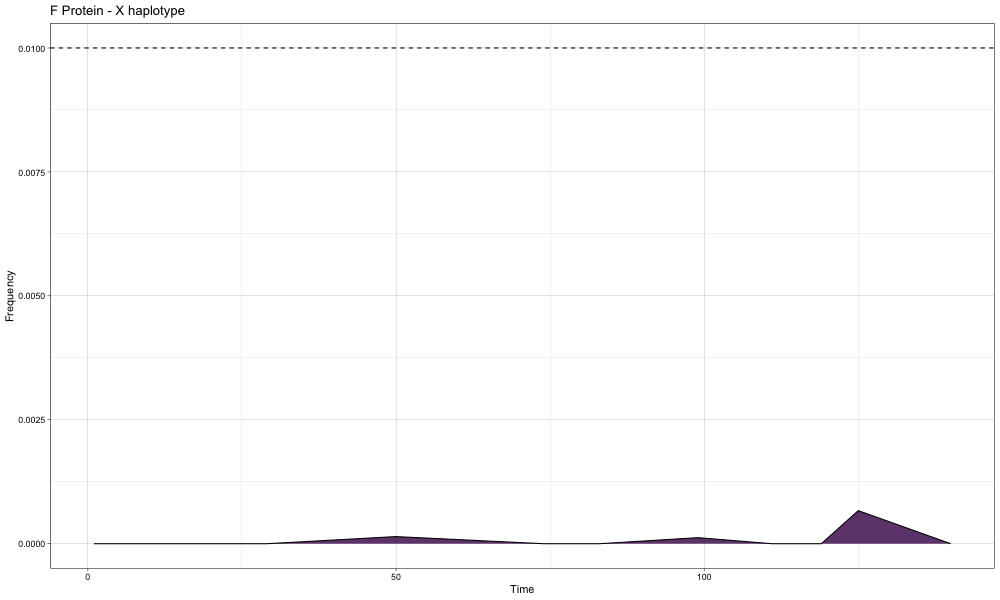

Temporary file deleted successfully.


In [169]:
# plot to check X haplotype frequencies

@rput haps # pass back to R
@rput protein_name

# Set the path for the temporary image file
output_path = joinpath(pwd(), "ggplot_output.png")

# Create the ggplot in R and save it as a PNG file
R"""

p <- haps %>% filter(str_detect(Haplotype, "^X+$")) %>% 
    ggplot(aes(x = as.numeric(Time), y = as.numeric(Frequency), fill = Haplotype)) + 
    geom_area(alpha = 0.8, linewidth = 0.5, colour = "black") +
    geom_hline(yintercept = 0.01, linetype = "dashed", color = "black") +
    theme_linedraw() +
    labs(title = paste(protein_name, "- X haplotype"), x = "Time", y = "Frequency") +
    theme(legend.position = "none") +
    scale_fill_viridis(discrete = TRUE, direction = 1)

png(filename = $output_path, width = 1000, height = 600)
print(p)
dev.off()
"""

# Read and display the image file in Julia
if isfile(output_path)
    img = load(output_path)
    display(img)

    # Delete the temporary image file after displaying
    rm(output_path; force = true)
    println("Temporary file deleted successfully.")
else
    println("File does not exist.")
end

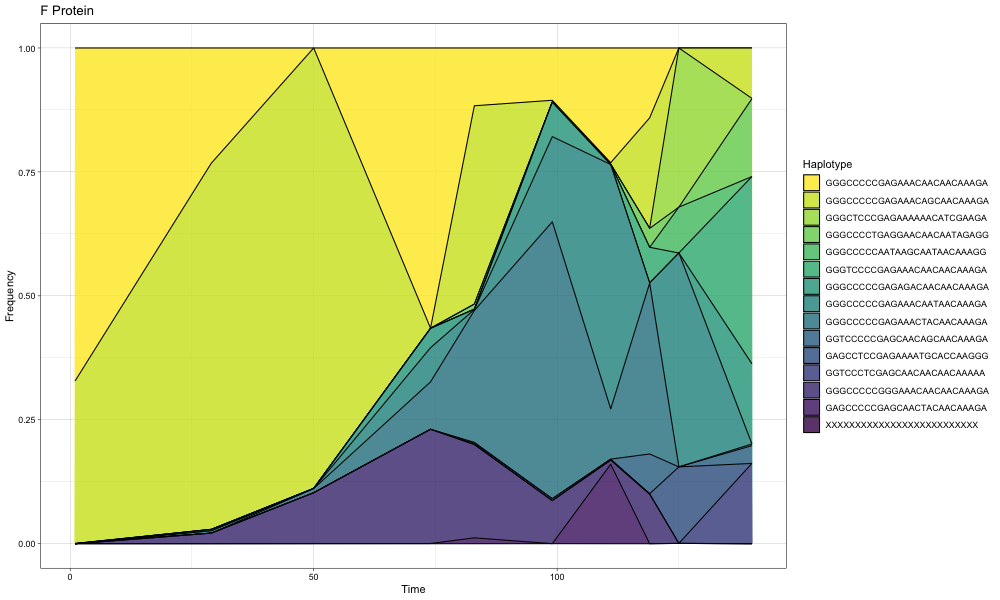

Temporary file deleted successfully.


In [170]:
# plot

@rput haps # pass back to R
@rput protein_name

# Set the path for the temporary image file
output_path = joinpath(pwd(), "ggplot_output.png")

# Create the ggplot in R and save it as a PNG file
R"""
# Sort haplotypes by their initial frequency
first_time_point <- haps %>% 
  filter(Time == min(Time)) %>% 
  arrange(desc(Frequency)) %>% 
  select(Haplotype, InitialFrequency = Frequency)

# Join the initial frequency data back to the main dataset
haps <- haps %>% 
  left_join(first_time_point, by = "Haplotype") %>%
  arrange(desc(InitialFrequency), Time, Frequency)

# Create a color palette with the same number of colors as unique haplotypes
num_haplotypes <- length(unique(haps$Haplotype))
haplotype_colors <- viridis::viridis(num_haplotypes, direction = -1)

# Assign colors based on the order of haplotypes by InitialFrequency
haps$Haplotype <- factor(haps$Haplotype, levels = unique(haps$Haplotype))

# Create the plot
p <- ggplot(haps, aes(x = as.numeric(Time), y = as.numeric(Frequency), fill = Haplotype)) + 
  geom_area(alpha = 0.8, linewidth = 0.5, colour = "black") +
  theme_linedraw() +
  labs(title = protein_name, x = "Time", y = "Frequency") +
  theme(legend.position = "right") +
  scale_fill_manual(values = haplotype_colors)


png(filename = $output_path, width = 1000, height = 600)
print(p)
dev.off()
"""

# Read and display the image file in Julia
if isfile(output_path)
    img = load(output_path)
    display(img)

    # Delete the temporary image file after displaying
    rm(output_path; force = true)
    println("Temporary file deleted successfully.")
else
    println("File does not exist.")
end

In [171]:
using DataFrames
using CSV

# Function to find the consensus haplotype at the minimum time point
function consensus_haplotype(df::DataFrame)
    # Find the minimum time point
    min_time = minimum(df[!, :Time])
    
    # Filter the dataframe for the minimum time point
    filtered_df = filter(row -> row.Time == min_time, df)
    
    # Group by haplotype and sum their frequencies
    grouped_df = combine(groupby(filtered_df, :Haplotype), :Frequency => sum)
    
    # Find the haplotype with the maximum summed frequency
    max_freq_row = grouped_df[argmax(grouped_df[!, :Frequency_sum]), :]
    
    return max_freq_row.Haplotype
end

# Call the function and get the consensus haplotype
consensus = consensus_haplotype(haps)
println("The consensus haplotype at the first time point is: $consensus")

The consensus haplotype at the first time point is: GGGCCCCCGAGAAACAACAACAAAGA


In [172]:
# Function to calculate mismatches
function count_mismatches(haplotype::String, consensus::String)::Union{Int, String}
    mismatches = 0
    for i in 1:length(haplotype)
        if haplotype[i] != consensus[i]
            mismatches += 1
        end
    end
    if mismatches == length(haplotype)
        return "X"
    else
        return mismatches
    end
end

# Add new column with mismatch count
haps.Mismatches = [count_mismatches(row.Haplotype, consensus) for row in eachrow(haps)]

println(haps)

# Group the DataFrame by the 'Mismatches' column
@rput haps
R"""
# Grouping by Time and Mismatches, then summing Frequency
haps_mismatched <- haps %>%
    group_by(Time, Mismatches) %>%
    summarize(Frequency = sum(Frequency), .groups = 'drop')
"""

@rget haps_mismatched

150×4 DataFrame
 Row │ Haplotype                   Time    Frequency    Mismatches 
     │ String                      String  Float64      Any        
─────┼─────────────────────────────────────────────────────────────
   1 │ GGGCCCCCAATAAGCAATAACAAAGG  1       0.000108336  5
   2 │ GGGCCCCCAATAAGCAATAACAAAGG  29      1.0e-10      5
   3 │ GGGCCCCCAATAAGCAATAACAAAGG  50      0.000272864  5
   4 │ GGGCCCCCAATAAGCAATAACAAAGG  74      1.0e-10      5
   5 │ GGGCCCCCAATAAGCAATAACAAAGG  83      1.0e-10      5
   6 │ GGGCCCCCAATAAGCAATAACAAAGG  99      2.44527e-5   5
   7 │ GGGCCCCCAATAAGCAATAACAAAGG  111     1.0e-10      5
   8 │ GGGCCCCCAATAAGCAATAACAAAGG  119     1.0e-10      5
   9 │ GGGCCCCCAATAAGCAATAACAAAGG  125     0.0925662    5
  10 │ GGGCCCCCAATAAGCAATAACAAAGG  140     1.0e-10      5
  11 │ GGGTCCCCGAGAAACAACAACAAAGA  1       1.0e-10      1
  12 │ GGGTCCCCGAGAAACAACAACAAAGA  29      0.00278285   1
  13 │ GGGTCCCCGAGAAACAACAACAAAGA  50      1.00249e-10  1
  14 │ GGGTCCCCGAGAAACAACA

Row,Time,Mismatches,Frequency
,String,Any,Float64
1,1,5,0.000288598
2,1,1,0.327615
3,1,3,2.0e-10
4,1,8,1.0e-10
5,1,4,0.000337723
6,1,0,0.671759
7,1,X,1.0e-10
8,111,5,0.000839678
9,111,1,0.605561


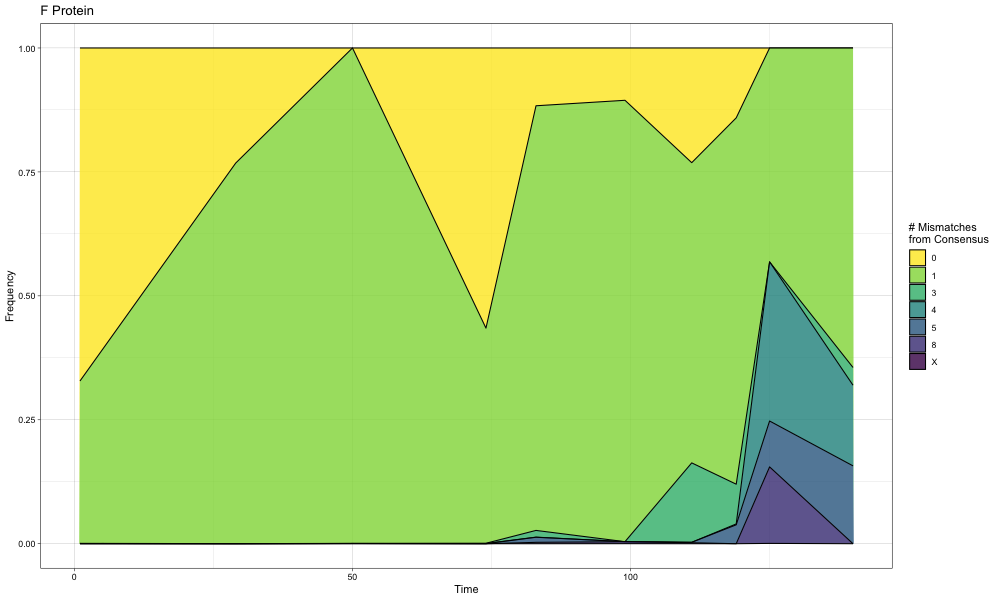

Temporary file deleted successfully.


In [173]:
# area plot for counts of mutations
# plot

@rput haps_mismatched # pass back to R
@rput protein_name

# Set the path for the temporary image file
output_path = joinpath(pwd(), "ggplot_output.png")

# Create the ggplot in R and save it as a PNG file
R"""
# Ensure columns are of correct types
haps_mismatched$Frequency <- as.numeric(unlist(haps_mismatched$Frequency))
haps_mismatched$Mismatches <- as.factor(as.character(unlist(haps_mismatched$Mismatches)))
haps_mismatched$Time <- as.numeric(unlist(haps_mismatched$Time))

p <- haps_mismatched %>% arrange(desc(Time)) %>% 
    ggplot(aes(x = as.numeric(Time), y = Frequency, fill = as.factor(Mismatches))) + 
    geom_area(alpha = 0.8 , linewidth = 0.5, colour = "black") +
    theme_linedraw() +
    labs(title = protein_name, x = "Time", y = "Frequency", fill = "# Mismatches\nfrom Consensus") +
    theme(legend.position = "right") +
    scale_fill_viridis(discrete = TRUE, direction = -1)

png(filename = $output_path, width = 1000, height = 600)
print(p)
dev.off()
"""

# Read and display the image file in Julia
if isfile(output_path)
img = load(output_path)
display(img)

  
# Delete the temporary image file after displaying
rm(output_path; force = true)
println("Temporary file deleted successfully.")
else

println("File does not exist.")

end

In [174]:
# Function to calculate Hamming distance between two strings
function hamming_distance(s1::String, s2::String)::Int
    return sum(c1 != c2 for (c1, c2) in zip(s1, s2))
end

# Function to group and order haplotypes by Hamming distance, starting with the consensus sequence
function group_haplotypes(strings::Vector{String}, consensus::String)
    # Ensure all strings are of the same length as the consensus sequence
    if any(length(s) != length(consensus) for s in strings)
        error("All strings must be the same length as the consensus sequence")
    end
    
    # Remove the consensus sequence from the list of strings if present
    remaining_strings = setdiff(strings, [consensus])
    
    # Initialize groups with the consensus sequence starting each group
    groups = [[consensus]]
    
    # Set to keep track of used sequences
    used_sequences = Set([consensus])
    
    # Function to find the closest strings to a given string from a list
    function find_closest_strings(s::String, candidates::Vector{String})
        distances = [(candidate, hamming_distance(s, candidate)) for candidate in candidates]
        sorted_candidates = sort(distances, by=x -> x[2])
        min_distance = sorted_candidates[1][2]
        return [c[1] for c in sorted_candidates if c[2] == min_distance]
    end
    
    # Build groups by progressively adding sequences with the smallest possible Hamming distance
    while !isempty(remaining_strings)
        # Get the last group
        current_group = last(groups)
        last_sequence = last(current_group)
        
        # Find the closest sequences to the last sequence
        closest_sequences = find_closest_strings(last_sequence, remaining_strings)
        
        # If there are multiple closest sequences, they branch in the group
        for seq in closest_sequences
            if seq in used_sequences
                continue  # Skip sequences that have already been placed in a group
            end
            new_group = current_group[1:end] # Clone the current group
            push!(new_group, seq)
            push!(groups, new_group)
            push!(used_sequences, seq)  # Mark this sequence as used
            deleteat!(remaining_strings, findfirst(x -> x == seq, remaining_strings))
        end
    end
    
    # Return the list of groups
    return groups
end

# Merge groups where one group is a subset of another
function merge_groups(groups)
    merged_groups = []
    
    # Sort groups by length (longest first) to prioritize larger groups during merging
    sorted_groups = sort(groups, by = length, rev = true)
    
    for group in sorted_groups
        merged = false
        for i in 1:length(merged_groups)
            if all(g -> g in merged_groups[i], group[2:end])  # Exclude the first sequence from duplication check
                merged_groups[i] = union(merged_groups[i], group)
                merged = true
                break
            end
        end
        if !merged
            push!(merged_groups, group)
        end
    end
    
    return merged_groups
end

# Extracting the Haplotype column as a list
haplotype_list = haps.Haplotype

# Filtering out entries that consist entirely of Xs
filtered_haplotype_list = filter(x -> !(all(c -> c == 'X', x)), haplotype_list)

# Establish consensus at time 0
consensus = consensus_haplotype(haps)

# Group by Hamming distance
groups = group_haplotypes(filtered_haplotype_list, consensus)

# Merge groups where one group is a subset of another
merged_groups = merge_groups(groups)

# Initialize an empty DataFrame
grouped_haps = DataFrame(Group = String[], Haplotype = String[])

# Iterate over the grouped vector and populate the DataFrame
for (i, group) in enumerate(merged_groups)
    println("Processing Group $i: ", group)  # Debugging line
    for haplotype in group
        push!(grouped_haps, (string("Group_", i), haplotype))
    end
end

# Apply the function to calculate Hamming distance and create the new column
grouped_haps.ham_dist = [hamming_distance(row.Haplotype, consensus) for row in eachrow(grouped_haps)]

# Convert Julia DataFrames to R dataframes
@rput grouped_haps
@rput haps_wide

# Use Tidyverse in R to join the dataframes by `Haplotype`
R"""
library(dplyr)

# Ensure Haplotype columns are of the same type (if not already)
grouped_haps <- grouped_haps %>% mutate(Haplotype = as.character(Haplotype))
haps <- haps %>% mutate(Haplotype = as.character(Haplotype))

# Join the dataframes on the Haplotype column with many-to-many relationship handling
grouped_haps <- left_join(grouped_haps, haps, by = "Haplotype", relationship = "many-to-many")
"""

# Bring the result back to Julia
@rget grouped_haps

Processing Group 1: ["GGGCCCCCGAGAAACAACAACAAAGA", "GGGCCCCCGGGAAACAACAACAAAGA", "GAGCCCCCGAGCAACTACAACAAAGA", "GGTCCCTCGAGCAACAACAACAAAAA", "GGGCTCCCGAGAAAAAACATCGAAGA", "GGGCCCCCAATAAGCAATAACAAAGG"]
Processing Group 2: ["GGGCCCCCGAGAAACAACAACAAAGA", "GGGCCCCCGGGAAACAACAACAAAGA", "GAGCCCCCGAGCAACTACAACAAAGA", "GGTCCCTCGAGCAACAACAACAAAAA", "GGGCTCCCGAGAAAAAACATCGAAGA", "GAGCCTCCGAGAAAATGCACCAAGGG"]
Processing Group 3: ["GGGCCCCCGAGAAACAACAACAAAGA", "GGGCCCCCGGGAAACAACAACAAAGA", "GAGCCCCCGAGCAACTACAACAAAGA", "GGTCCCTCGAGCAACAACAACAAAAA", "GGGCCCCTGAGGAACAACAATAGAGG"]
Processing Group 4: ["GGGCCCCCGAGAAACAACAACAAAGA", "GGGCCCCCGGGAAACAACAACAAAGA", "GGTCCCCCGAGCAACAGCAACAAAGA"]
Processing Group 5: ["GGGCCCCCGAGAAACAACAACAAAGA", "GGGTCCCCGAGAAACAACAACAAAGA"]
Processing Group 6: ["GGGCCCCCGAGAAACAACAACAAAGA", "GGGCCCCCGAGAGACAACAACAAAGA"]
Processing Group 7: ["GGGCCCCCGAGAAACAACAACAAAGA", "GGGCCCCCGAGAAACAATAACAAAGA"]
Processing Group 8: ["GGGCCCCCGAGAAACAACAACAAAGA", "GGGCCCCCGAGAAACAGCAAC

Row,Group,Haplotype,ham_dist,Time,Frequency,Mismatches
,String,String,Int64,String,Float64,Any
1,Group_1,GGGCCCCCGAGAAACAACAACAAAGA,0,1,0.671759,0
2,Group_1,GGGCCCCCGAGAAACAACAACAAAGA,0,29,0.232206,0
3,Group_1,GGGCCCCCGAGAAACAACAACAAAGA,0,50,1.00261e-10,0
4,Group_1,GGGCCCCCGAGAAACAACAACAAAGA,0,74,0.565105,0
5,Group_1,GGGCCCCCGAGAAACAACAACAAAGA,0,83,0.11658,0
6,Group_1,GGGCCCCCGAGAAACAACAACAAAGA,0,99,0.105521,0
7,Group_1,GGGCCCCCGAGAAACAACAACAAAGA,0,111,0.231366,0
8,Group_1,GGGCCCCCGAGAAACAACAACAAAGA,0,119,0.140912,0
9,Group_1,GGGCCCCCGAGAAACAACAACAAAGA,0,125,1.0e-10,0


HTML{String}("<img src=\"data:image/gif;base64,R0lGODlhWAJYAoAAAAAAAAAAACH/C05FVFNDQVBFMi4wAwEAAAAh/gdnaWYuc2tpACH5BAQUAAAALAAAAABYAlgCh////wAAAOfn5+bm5v7+/v39/f3lHtzc3HR0dKOjo3d3d2pqaurq6vz8/Pr6+ujo6Ozs7Pv7++/v7/Ly8vn5+ff39/Pz8/j4+Onp6fX19fb29u3t7evr6/Hx8bDgUvT09O7u7vDw8PzlHuTk5OXl5e7jHwQEBCUlJQ4ODhMTEyEhITU1NYODgxwcHDk5OampqeHh4dfW10BAQCcnJysrK1paWkxMTGBgYLe3t1CzjEuek1ZWVr/iS2XHe23LdXvSbVa7hl5Jh4bWaF5Egk9+lY6Ojk6DlZfbXl89ehgYGE2KlVJSUkymkVpYkB8fH10zcEVFRXl5eT09PdnZ2bm5uWRkZDExMcLCwq3dTdLR0q2trV0zatvb21djkwkJCePj49TU1M7OzoiIiJOTk0ualUlJSXt7ey8vL8vLy09PT/3nHm5ubsXFxYuLi7u7u56enqGhod/f3v/+7eDoRdjnRsvmSbGxsX9/f1ZnlE5OTrThUKfeVl9BfkyTlY7ZY1q+g+/pRkuWlVNxlU2OlVzBgnZ2dkyRlfXpSFF4lV1TjFZqlE2sj+foRU6ujaHdWllckVK2iGDCfllfkU2qj1F7lUuiktLlRlRulV1WjV5OiVJ0lU2HlV5Qi1VslVF2lV84dmdnZ+Lzvf3rS5ubm5eXl+Li4vzkHrrM1XFxcarcRrjW087C0rW1tXPPc/3wd73kZ12inrne0sDny7+wyLzC1MDAwKampr6+vvLkH9Dvw7640MnJyff2td/X4er30f3+9/LsX3TLjWe/l6jiqP3kH/j98WWPoZSeuvL64mqFo3FMgc/l3W9pm0SsgsfHx2E5bX21srXiXL7eLefiIP7pOkB0jZfNt4rWhXJWjGKYoXFflWK0nWl8oc7sk9bsrO/29P7//qTFxGKpojiMiKfgcJbceG1yn///3sbnhf/0l/7nLvrkINzn4Ye4t5J5mWatpPf8+sTV1SuGgiGAfNvhIfn6+arZxtPr4ej18O7q797r6+fm5yB/e0oeV5ujv+Pr7wj/AAEIHEiwoMGDCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEOKHEmypMmTKFOqXMmypcuXMGPKnEmzps2bOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qc8iUMfYwnCxwhinWLNq3cq1q0ATUnbYoOHlTcUGNVJ4Xcu2rdu3LE24GTjGS4yJYFa0UAu3r9+/gAMflEuQBgIAEe6c8DLjBQAFUQbaoEKQhZhbfAVr3sy5M1LCA6uUATDKCZcOd1BEwJHCAQAwKDQYvJLZs+3buHO7BC3wzgoAAuIA2PAiAIgCLewAKFTlYK3auqNLn06dIm8ANXYA4HCjRQsbATgA/4iyAzkb59Crq1/PfjpvCSlIAdhRBsbrAAwATPHC6gTC5+0FKOCAm5lgSylTUCHDDBUAUMZhBNwQwAgCSTEDC/+lR+CGHHbYlAkBBGBCC1UIINAVM5zghBhJUAbAGwHYh56HNNZoo1MCFFDQG6Pd6OOPQDYFAylO4BDkkUgm6RMXUMin5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcGJUhgJ01mnnnXjmqeeefPbp55+ABirooIQWauihiCaq6KKMNuroo5DqiQqNC8Rp6Y+HeVjppZzSmGmHm3YqKoGfchjqqKiyV+qGp6bq6nSrEv/Y6qu04hbrgLPWqitntwqY667AAtZrgL8Ga+xbw7ZX7LHMepUse8s2K21Wz64X7bTYLlWtetdm661R21bX7bfkBhUudeOWqy5P506X7rrw3tSudO/Ga69M80ZX7738tpSvbvv2KzBK/+YW8MAIj1Qwbgcn7LBHC9/W8MMUZxSxbROT2wAFFWSQwQcWTNBBCBKAAMIGEHCgMgQbgCCBBCF0MIEFH2SgQQUO6FgxQRd7ljGwBERwgQYWhAACBw8MQMIDDJgMs8w013zzBRQ4QMEFFWjwccgikywBBAwIQIIAGEAAQgcfaEBBBAj33NnPqTZwgQUSMDAA2RycbYEGF0T/QMBIBThwQQZFb4D03RCE8AEFOq/rNmdwWxqBBhOAgMHYiWfA+E1y083BAAMwIIEFFTTw7eObRc5mBBnUTQIGG3SggQN/C1UABRmEAIEAoXdQQePHoq6Z6mdSYAEEAzwAwgeuZUXBBMgrz7yxwgtGfJgNaBACAyQwEMLvbrEuAQYDcDDBBbW/Wn1g13dZgQQPCLCBBRRoRsAFE3zOwATNo7o+YO3DUgM+gDwOWMB0uaFAB8gHAg2k71L/+0sAqaRABjpQPQMsoAXYZqkI+mWCTyKABkAQOv5t6AIhEMADQnABOHmwLyBEUgU2MIANZAB4HYqABT4ngfqx6YVwieGP/ygggfJlAEkFsAAGHjABBKIJiG8RYo0aMIE4YMACOESSA0IwABh8IIthgqJbpMihAnwgbCEgQQupZAHl1bBBZBJjW8g4oBkOAARrpFuVMFA/AmTgcyHo35fkyBY6socAH2DaBQdSgAFQyQEPKIgZBcABOHqJkGsxZHUawMUN+NAgEJCNlEIwAYRogAEP+MADs4RJr2hSOhSgYQeceBANQGBKAqClQRxAwhDo0kqt7Morc3PKVK4SIQMAY5AukB+GFKADNfwkMCllJQJMQAAQWKNDRhel5UEkAxjAwBGnqSkqPVMAEuAgRJgJJQIM4JgMuQAEUlmlYHJlmPabwABCAP9PhwhAnUjKwAYqEoF5jjNK9twKPgFjzQFI4JcR6UAHnlTJi1AAaaJ8UkK1slC/WEAAIICoRCJgopg0wAEV+MAEJIAyDjBgifFT2ghIIFOaqhADDGAAB8xGygxcIGcmdWRGmIkBSyJpo1np6Fs+ID+AYoQB2izJ7TLQgaORb2wM2IAEJuBTqlUtAg0owDEJQIACNCACVrsA1j7Qga9hQGxkM9sEZtdPkOhxIxXAaVSBhFSsKJUtGcCmIDVyV5B0TgKfC93o+BYBZX4kcIOr3OWwGQLNOTYjfPRIXhkgTR/11Sl/7coFMMCBzm6kkR1xwAdAwD3KLu6yLTms3cpXWZH/UgSSIdHAAyDg1Bp9timh1UoDNvAA03YklBcpQAU68DkMSICuQ7ndank3P+NGhJQjycAAOlBXUlHTRvosJUlsORHxJQ0C5+tudLXHPe9pALYIySVJCgACAWTUU9/10AUesAHbeiSZDhFhfaXXW60YbwNkY+FDKtDMklCAtAUe0G+ZEtylDPcBeyUJNxWiw8/ZEL5cicAE7PbhhXgTJR/YrnrVM+GlVDgp+rTASth5kAtIQIUK7oyASzhYgbhzxR6hr3071GKlvNgoFeAviEHyz4H4UYMR7kwFHRpVgbbkwRyIcnWKnJQjRxcEGH6JRAFwARJuoAJA9kwDMoBG11TU/yVMFa+AuIwULwelAgKQs0s0MAUBMECVG6Ji0riwZJEQAGxajg6dj2JnnxAAftY9SRKXGIeDeggCMDBimkOi3Q8EaNFGaTRPKIDOTX9EAzys32pt9ADX2LGHLmmAyvxrq/xSJ4UZlvQ1z0wQ1NIIt4z8QDgtrRILDIDY0gF1UUSNEwfAztQciUAR03kQ5HoIuwaRZ54L3ZEIwI7bgVE2UZhtk2veFyUV4MC2E0JeD8kXIdJ2aI9N0gEBGFU34h4KuWfSAAZAANwZQaQiGwJgDlVAPAshwEffnBIKPEAC0O5LvoWy75jg2dMpKYA+PfmQDW/Ihg85JQYwjhIChOABif8WzMSDUnExozwlDZ1lRGhMoB9HxAEGVYkGBnBvz6wcKC1nSQF2GnGLNPShFGkygaw8kYs+4NwkgeREa11O2zhAAFM/yUdDapExE4jhEyFqz
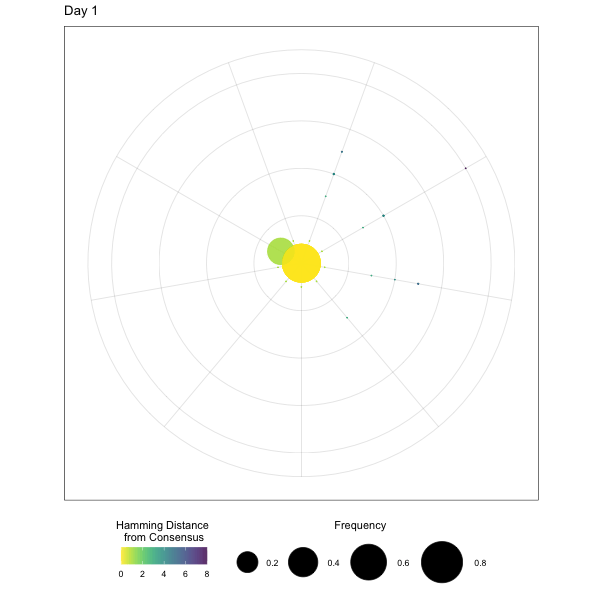

GIF successfully saved at /Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/VeTrans/by_protein/n_haps_F/Inference_14_0_circles.gif


In [175]:
# circles animation

# Define the gif_path by replacing .csv with .gif in haps_path
gif_path = replace(haps_path, ".csv" => "_circles.gif")

# Extract the directory name from gif_path
dir_path = dirname(gif_path)

# Ensure the directory exists
if !isdir(dir_path)
    mkpath(dir_path)  # Create the directory if it doesn't exist
end

# Pass the `grouped_haps` dataframe and `gif_path` to R
@rput grouped_haps
@rput gif_path

# Run the R code to create the animation and save it
R"""
# Find the min and max frequency
global_min <- min(grouped_haps$Frequency, na.rm = TRUE)
global_max <- max(grouped_haps$Frequency, na.rm = TRUE)

# Use these in ggplot with consistent size scale
size_limits <- c(global_min, global_max)
size_range <- c(0, 20)

# Create the ggplot
p <- grouped_haps %>%
    ggplot(aes(x = Group, y = as.numeric(ham_dist), color = as.numeric(ham_dist), size = Frequency)) + 
    geom_point() +
    theme_linedraw() +
    labs(title = 'Day {round(frame_time)}', x = "Group", y = "Hamming\nDistance", size = "Frequency", color = "Hamming Distance \nfrom Consensus") +
    guides(size = guide_legend(title.position = "top")) +
    theme(legend.position = "bottom", 
          legend.title = element_text(hjust = 0.5)) +
    guides(colour = guide_colourbar(title.position = "top", title.theme = element_text(hjust = 0.5))) +
    scale_color_viridis(direction = -1, alpha = 0.8) +
    scale_size_continuous(limits = size_limits, range = size_range) +
    coord_polar(theta = "x", start = 0) +
    ylim(0, max(grouped_haps$ham_dist)) +
    theme(axis.title.x=element_blank(),
          axis.text.x=element_blank(),
          axis.ticks.x=element_blank()) +
    theme(axis.title.y=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks.y=element_blank()) +
    transition_time(as.numeric(Time)) +
    ease_aes('linear')

# Render the animation as a GIF
anim <- animate(p, renderer = gifski_renderer(), width = 600, height = 600, fps = 5, end_pause = 50)

# Save the GIF to the specified path
anim_save(gif_path, anim)
"""

using Base64, IJulia

# Check if the file was saved successfully
if isfile(gif_path)
    println("GIF successfully saved at $gif_path")
    
    # Read the GIF file
    gif_data = read(gif_path)
    
    # Encode the GIF data to base64
    base64_gif = base64encode(gif_data)
    
    # Create an HTML image tag with the base64-encoded GIF
    img_html = """<img src="data:image/gif;base64,$base64_gif" />"""
    
    # Display the HTML directly
    display(HTML(img_html))
else
    println("Failed to save GIF at $gif_path")
end

The next plot requires input from Blanche (https://github.com/cjri/Blanche.git). 

In [176]:
using CSV
using DataFrames

# Define the file paths
blanche_path = "/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/Blanche/F/Consensus0_F_14_haplotypes.dat"
names_path = "/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/Blanche/F/Consensus0_F_14_haplotypes.txt"

# Read the .dat file and select the first two columns
df_coords = CSV.read(blanche_path, DataFrame; header=false, delim=" ", select=[1, 2])

# Read the .txt file containing the haplotype names
names = DataFrame(Haplotype=readlines(names_path))

# Combine the two DataFrames
blanche = hcat(df_coords, names)

# Rename the columns to "x", "y", and "Haplotype"
rename!(blanche, [:x, :y, :Haplotype])

# Find the coordinates of the consensus haplotype
consensus_coords = blanche[blanche.Haplotype .== consensus, [:x, :y]]
if nrow(consensus_coords) == 0
    error("Consensus haplotype not found in the dataframe.")
end

consensus_x, consensus_y = consensus_coords[1, :x], consensus_coords[1, :y]

# Compute the adjustment amounts
blanche.x .-= consensus_x
blanche.y .-= consensus_y

# Set the coordinates for the consensus haplotype to (0, 0)
blanche[blanche.Haplotype .== consensus, :x] .= 0.0
blanche[blanche.Haplotype .== consensus, :y] .= 0.0

# Join the updated coordinates with grouped_haps
grouped_haps = innerjoin(grouped_haps, blanche, on=:Haplotype)

# Display the joined dataframe
grouped_haps

Row,Group,Haplotype,ham_dist,Time,Frequency,Mismatches,x,y
,String,String,Int64,String,Float64,Any,Float64,Float64
1,Group_1,GGGCCCCCGAGAAACAACAACAAAGA,0,1,0.671759,0,0.0,0.0
2,Group_1,GGGCCCCCGAGAAACAACAACAAAGA,0,29,0.232206,0,0.0,0.0
3,Group_1,GGGCCCCCGAGAAACAACAACAAAGA,0,50,1.00261e-10,0,0.0,0.0
4,Group_1,GGGCCCCCGAGAAACAACAACAAAGA,0,74,0.565105,0,0.0,0.0
5,Group_1,GGGCCCCCGAGAAACAACAACAAAGA,0,83,0.11658,0,0.0,0.0
6,Group_1,GGGCCCCCGAGAAACAACAACAAAGA,0,99,0.105521,0,0.0,0.0
7,Group_1,GGGCCCCCGAGAAACAACAACAAAGA,0,111,0.231366,0,0.0,0.0
8,Group_1,GGGCCCCCGAGAAACAACAACAAAGA,0,119,0.140912,0,0.0,0.0
9,Group_1,GGGCCCCCGAGAAACAACAACAAAGA,0,125,1.0e-10,0,0.0,0.0


In [177]:
# create mutation annotations for each haplotype

# path to single_locus_trajectories file
sl_traj_path = "/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/samfire/single_locus_trajectories/by_protein/single_locus_trajectories10_F_Fusion_protein.out"

using DataFrames

# Function to load the first column from the .out file into a DataFrame
# Function to create the loci DataFrame and add haplotype columns based on the `names` DataFrame
function create_base_loci(filepath::String, consensus::String, names::DataFrame)
    # Initialize an empty Set to store unique first column integers
    first_column_set = Set{Int}()

    # Open the file and read each line
    open(filepath, "r") do file
        for line in eachline(file)
            # Split the line by spaces and convert the first element to an integer
            push!(first_column_set, parse(Int, split(line)[1]))
        end
    end

    # Convert the Set to a sorted vector to create a DataFrame
    first_column_vector = sort(collect(first_column_set))
    
    # Check that the length of the consensus string matches the number of unique loci
    if length(first_column_vector) != length(consensus)
        error("The length of the consensus string must match the number of unique loci.")
    end

    # Create a DataFrame with the extracted unique integers and the consensus_base
    loci = DataFrame(locus = first_column_vector, consensus_base = collect(consensus))
    
    # Iterate over each row in the names DataFrame
    for row in eachrow(names)
        haplotype_string = row[:Haplotype]  # Get the sequence string from the Haplotype column
        column_name = haplotype_string  # Use the haplotype string as the column name

        # Initialize the new column with empty strings
        new_column = Vector{Union{Char, Nothing}}(nothing, length(loci.consensus_base))

        # Fill the new column, skipping matches with the consensus
        for j in 1:length(haplotype_string)
            if haplotype_string[j] != loci.consensus_base[j]
                new_column[j] = haplotype_string[j]
            end
        end

        # Add the new column to the loci DataFrame
        loci[!, Symbol(column_name)] = new_column
    end
    
    return loci
end

# Load the first row of the single_locus_trajectories file
loci = create_base_loci(sl_traj_path, consensus, names)

loci


Row,locus,consensus_base,GGGCCCCCAATAAGCAATAACAAAGG,GGGTCCCCGAGAAACAACAACAAAGA,GGGCCCCCGAGAGACAACAACAAAGA,GGGCCCCCGAGAAACAATAACAAAGA,GGGCCCCCGAGAAACAGCAACAAAGA,GGGCCCCCGAGAAACTACAACAAAGA,GGTCCCCCGAGCAACAGCAACAAAGA,GAGCCTCCGAGAAAATGCACCAAGGG,GGTCCCTCGAGCAACAACAACAAAAA,GGGCCCCCGGGAAACAACAACAAAGA,GGGCCCCTGAGGAACAACAATAGAGG,GGGCCCCCGAGAAACAACAACAAAGA,GAGCCCCCGAGCAACTACAACAAAGA,GGGCTCCCGAGAAAAAACATCGAAGA
,Int64,Char,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…
1,5778,G,,,,,,,,,,,,,,
2,5882,G,,,,,,,,A,,,,,A,
3,5899,G,,,,,,,T,,T,,,,,
4,5925,C,,T,,,,,,,,,,,,
5,6005,C,,,,,,,,,,,,,,T
6,6148,C,,,,,,,,T,,,,,,
7,6169,C,,,,,,,,,T,,,,,
8,6223,C,,,,,,,,,,,T,,,
9,6280,G,A,,,,,,,,,,,,,


In [178]:
# create dataframe of variant positions per haplotype

# Melt the DataFrame to long format, excluding `locus` and `consensus_base`
melted = stack(loci, Not([:locus, :consensus_base]), variable_name=:haplotype, value_name=:variant_base)

# Define a function to check for undesired values
is_valid_variant(value) = !ismissing(value) && value ≠ "N/A" && value ≠ nothing

# Filter out rows where `variant_base` is missing, "N/A", or nothing
filtered = filter(row -> is_valid_variant(row.variant_base), melted)

# Select only relevant columns
variant_loci = filtered[:, [:locus, :consensus_base, :haplotype, :variant_base]]

# Create the 'variant' column by concatenating values
variant_loci.variant = string.(variant_loci.consensus_base) .* string.(variant_loci.locus) .* string.(variant_loci.variant_base)

# Filter for only helpful columns
variant_loci = variant_loci[:, [:haplotype, :variant]]

# Group by "haplotype" and concatenate "variant" values with newline separator
grouped = groupby(variant_loci, :haplotype)
variant_loci_merged = combine(grouped, :variant => (v -> join(v, "\n")))

# Rename the merged column
rename!(variant_loci_merged, :variant_function => :variant)

# Rename haplotype column for joining
rename!(variant_loci_merged, :haplotype => :Haplotype)



Row,Haplotype,variant
,String,String
1,GGGCCCCCAATAAGCAATAACAAAGG,G6280A\nG6302T\nA6378G\nC6528T\nA7174G
2,GGGTCCCCGAGAAACAACAACAAAGA,C5925T
3,GGGCCCCCGAGAGACAACAACAAAGA,A6306G
4,GGGCCCCCGAGAAACAATAACAAAGA,C6528T
5,GGGCCCCCGAGAAACAGCAACAAAGA,A6518G
6,GGGCCCCCGAGAAACTACAACAAAGA,A6507T
7,GGTCCCCCGAGCAACAGCAACAAAGA,G5899T\nA6305C\nA6518G
8,GAGCCTCCGAGAAAATGCACCAAGGG,G5882A\nC6148T\nC6450A\nA6507T\nA6518G\nA6548C\nA7038G\nA7174G
9,GGTCCCTCGAGCAACAACAACAAAAA,G5899T\nC6169T\nA6305C\nG7042A


In [179]:
# join variant_loci to grouped_haps for annotation

grouped_haps = leftjoin(grouped_haps, variant_loci_merged, on=:Haplotype)


Row,Group,Haplotype,ham_dist,Time,Frequency,Mismatches,x,y,variant
,String,String,Int64,String,Float64,Any,Float64,Float64,String?
1,Group_1,GGGCCCCCGGGAAACAACAACAAAGA,1,1,1.0e-10,1,-0.586212,0.68828,A6293G
2,Group_1,GGGCCCCCGGGAAACAACAACAAAGA,1,29,0.0214396,1,-0.586212,0.68828,A6293G
3,Group_1,GGGCCCCCGGGAAACAACAACAAAGA,1,50,0.102676,1,-0.586212,0.68828,A6293G
4,Group_1,GGGCCCCCGGGAAACAACAACAAAGA,1,74,0.230446,1,-0.586212,0.68828,A6293G
5,Group_1,GGGCCCCCGGGAAACAACAACAAAGA,1,83,0.188106,1,-0.586212,0.68828,A6293G
6,Group_1,GGGCCCCCGGGAAACAACAACAAAGA,1,99,0.0866705,1,-0.586212,0.68828,A6293G
7,Group_1,GGGCCCCCGGGAAACAACAACAAAGA,1,111,0.00838221,1,-0.586212,0.68828,A6293G
8,Group_1,GGGCCCCCGGGAAACAACAACAAAGA,1,119,0.0996502,1,-0.586212,0.68828,A6293G
9,Group_1,GGGCCCCCGGGAAACAACAACAAAGA,1,125,1.0e-10,1,-0.586212,0.68828,A6293G


HTML{String}("<img src=\"data:image/gif;base64,R0lGODlhWAJYAoAAAAAAAAAAACH/C05FVFNDQVBFMi4wAwEAAAAh/gdnaWYuc2tpACH5BAQUAAAALAAAAABYAlgCh////+Tk5PHx8ePj4/Ly8gAAAHR0dHd3d/z8/Ht7e83NzbW1tfzlHpzZJ/7+/nZ2dvr6+vn6+f3+/fv7+3JycoqKinl5eaenp8nJyZCQkJWVldPT035+fjk5OYSEhJiYmLm5ucDAwMvLy+np6fb29vj391VVVY6OjuHh4ebm5p+fn9fX1xoaGpycnFpaWqysrIyMjN3d3YCAgO7u7mRkZIaGhtbW1lJSUvj4+O3t7X19fW9vb4ODg9HR0ZOTk/T09KGhod/f32dnZ7u7uzUASqioqExMTO/v74eHh7Ozs87Ozm5ubr6+vqKiomlpabCwsJGRkWtrazU1NWJiYnh4eJmZmR4eHl1dXSAgIMfHxzExMScnJw0NDdnZ2fDw8E5OTsLCwkNDQ/Pz9LGxsS0tLRERESNge66uriQkJJ2dncPDw+zs7Nra2ixBeV9fX+vr63jROIrVLyVZezi0XiZTe2PKRB+RdS2qZyekayCXcjIuczYeaiBvezQocDcOWzYYZR91eyhOegkJCaWlpUhISM/Pz6qqqkZGRkpKSurq67u6uwUFBUBAQJaWltjY2Jqamra2th6BeiIiIjoMU0q+UyoqKi46d9vb2+Li4hUVFT09PczMzLy8vLS0tDs7O+fn5729vcXFxR59eiSgb7e3t+/jGqOjo1nGSlTETkO7VzYkbZbXKj64WzcUYW3NPzYEUjKvYyJneyFqe6jaIsLeGR6Md9ThFh6IdypJeufjFzA0dbjdHC82dh95eh6GeCKcbypGebDcHiJke/jlHN3hFcvfF8TExKjdQPzzmj8/Pzw8PPb43XWzrdnwqUhhjKLTxUB0jP33uzyIi6PIycrqovfnN+b1yYhqka6qxUtNh6m6ypHYk66dvKfbwqTAyb/mdHLPZD2Vi0y0gr/pturyoD+pgqykwnyFqrPhWKGzxtzu6U8hY9bkNEaej1A2eVK+c6yXtcfZ2rnQ1U9BgYfWVFEsb63hvaiwyPzrX2lDc77hOl7Fa5rbSrPkuuHtyoSMrwj/AAEIHEiwoMGDCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEOKHEmypMmTKFOqXMmypcuXMGPKnEmzps2bOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0KckFMGCcUKEEYw9STrNq3cq1q1cALiSZuNFBkAkJFQNYcfK1rdu3cOOudEFjYCEWFSg2KcOCrdy/gAMLHmyQLkEeVgSSksKl74QQUhAI9EGhICJFUfwS3sy5s+ejhgeCKCBmxCJDJcAsShIhE1YAlc4czPy5tu3buGGGFrihAIofhQDg2ITmA4AdVwBsygRhtubc0KNLn05xN4AxiyTDqFQmDItGAAoJ//qxZAdC2tTTq1+f3rqLMABelAkleYsPgVouZKrqnL3//wBu5oILmASRxQGLGAOAClhMcF0BJwgExRZkJIRegBhmqKFWLhTgYSZhMCEQCYewsMUNoa2xSITnPbfhizDGmNQRPxS0BhdvyKjjjjw6pYIRU/Qo5JBE/nSFEGIUqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmhhB4sYBcMYp55x0zulEnXjmqeeefM65Q5+ABiqonHcOauihdVKA6KKLFsroo4H+CemkfDpK6aV0SorppnFaaugDCay0gAIaBeCTAD6Z2hMBPg1waqqv9v+kKkUIhKrSqKXGytOsO7Hak6s9oSqrrjvxKlGtopKakbE5CburT77yBCxPzhZLrE7MQoTsrcpilO1N1WILbavX5vStTeGaa9G2KeG6bLk4nVtTtDtNu1O68cJ7k7wMsYuSu97qaxO/M9Grk7064buvwDURrJC/JwF8kcMxKTzwuL8yTBPFMFnc8Lq2ttvtxBrPxPFLBueEcLOwBtsyrSH/O7JFJ7vk8cYYS1uyTDW3dLPJICebq8vDrkou0c8ibW1FEJskMc07x9QzSynjtDJOP/McNUxTD9R0SU+ntfVLXatU9U1Xg/vyvWsfG3PEM4uttLhGZzy3unfny/TbTsf/TVHZKWUtdc71ju0S4CgJznXQ3A5Nbds5nW1T2uhCjrXlD339lN8TIX6S4mQTfrDhLXluEuiHMy6y42wXzZPkNVFeE+qlk84S4JqPFPbftq9kekmw0yQ7TbTf3rtKuPNd0QgYYLACQQOAIRlBu3d+fEq/kxT8TMPPVLzv16OU/EYWTGHBIwMpYkT5BVUvUfYjfY+86CqHfxL8IsmPveoYGfEGvUaYAQAQkQPqce599jMJ/kKyPZl0Tyb6E18CSzI+jWBhCYQwjkA6IBAhBIcEHODAAyAxgBKa8IQoTCEKMaDCFrrwhTCMIQptIMMa2vCGJ2QhDnfIQxWuoIdABKIO/4NIRBvSsIhIjOEQk8jEFB6xiVA04RJ3GIQDbARVE9CCAzYokCmwQSA4wMEYDhiRBYIkgvejn9UmSBIzfgSNCuSfRSZQmRJwUCAmQAEAGBEBA7IuYZizSQMXUoQKYCACRUjCgoAAAEhAAQKK8AAoNEAFD2xAIg+sWCBnt8l+KY8iFbiCG0AAAA724AZfuI8f35W3hdWtIiCQTRPGYAM1YGAQGihEAm7JA1VZYHoRyWTHOuk9Yj7skxTpo0FwYBD3lZGNI3GjRwaZkArkCAAyOMESzqAATgziEUeoABSKEKFfTkSYL4EjBaEpkgqujpWPc12vLgKGJkwgAYMIAAe6gP/LSyAhFIY4AwRCZU5MsjMk0uyIOtsox779kWXy1Ak1E9IJGDgCB4OARHwMAYAQfEACGGhBATmxRYO28mIn/djehAbP1iXtdUeL50tdujSYsTRgKcXZKwuXU6D1VGsrbVxLARnRyMWUpnSTaU0nkjuROBMiCeXIQqOpRm35oAJBQKQiCaDICnhgBo5sjg9IcM6DgiSqVzRmQpoakqc+BK0amWo7q/oQGMRgAoOgpRoAAAMd5KACXvjBLgfxhiWooKw/HVxiFxfUd+JUqUmdp0UMMJBsLmEMPeBADBqxAwyAswInAIEbEAtZvJVWbzYV6mORalrJVsQHPSAAD/LJgRb/VOAQGyiEIUTwT0M4YQgJ4A9E0GkztQ6zqNpCplPJCFWzfgSuGZnoQSSgAiiMAKMa7Sh1F9DRDxwhFAAggIiC6VyPQBcjckVoQ8HG3LeWtyPnvUjwghAOsr6EuD4zbjr1axC2gsStDomvRdJ7VroKJBKiaAdM8MsSAj/3vRxxp8weejnk3iR46giHMl3C4JU42LwQ3oiE4UZhtVlYkBhxQI0A4CAWt7gEAoGAA3JAY2A+pMMq+TB8Q1xih/j3IwBuiIArouMIG9ghnHABANgAhQT0gAYZAEAQTACAA3BgA404RCOOYNLTutLLKE2tY0m22NDtlCIJaEIPGgGFFzSB/wNAQAASOACAJUThEgB4AEVwHDj+5vfEDfmxR4LMkCFTpMgiPjJDjmCEGlDAAyPwQAwk4IETWIAQusRAGvK8Zx4PFaIzddtNyQxmlcLUIhr4IgWyAIUdDKECPEBABBKAAB0YktOkZS1qdf1lpiq3re0NsKdXK1GOTM/GAkF2l3kdZmab2tejhlqZU3fm+k27dtc2XmMn/OkKh9qodiu1TsXtUzFzm9igXmqxL7JiADTH3QBwwASmx0wAfAItyybqt72t7ogIuiOEXoihJ4LoHs/rIg7ALQAygAQlwMAHT1CBDIoAAQOc4QgGaIITYEzebIPP4/PbNom7beJ9X/giIf8YQwIIQAMYeAEJFkiCAaAwhBmQ4gwtYEMJYtDuGw+b1M4eN7RVC3R99xsn0jVIFGBwiCB4IACcxQQHTEUFAPTgDCroQQ8ooIh8pzuyRge7v
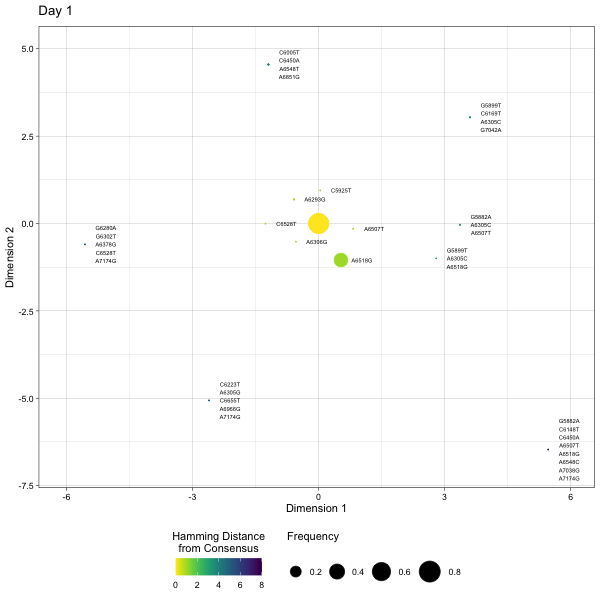

GIF successfully saved at /Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/VeTrans/by_protein/n_haps_F/Inference_14_0_points.gif


In [180]:
# Define the gif_path by replacing .csv with .gif in haps_path
gif_path = replace(haps_path, ".csv" => "_points.gif")

# Extract the directory name from gif_path
dir_path = dirname(gif_path)

# Ensure the directory exists
if !isdir(dir_path)
    mkpath(dir_path)  # Create the directory if it doesn't exist
end

# Pass the `grouped_haps` dataframe and `gif_path` to R
@rput grouped_haps
@rput gif_path

# Run the R code to create the animation and save it
R"""

# Create the ggplot
p <- grouped_haps %>%
    ggplot(aes(x = as.numeric(x), y = as.numeric(y), color = as.numeric(ham_dist),
        size = as.numeric(Frequency), label = variant)) + 
    geom_point() +
    theme_linedraw() +
    labs(title = 'Day {round(frame_time)}', x = "Dimension 1", y = "Dimension 2",
        size = "Frequency\n", color = "Hamming Distance\nfrom Consensus") +
    geom_text(size = 2, color = "black", nudge_x = 0.5, nudge_y = 0, 
        check_overlap = T, na.rm = TRUE) +
    guides(size = guide_legend(title.position = "top")) +
    theme(legend.position = "bottom") +
    guides(colour = guide_colourbar(title.position = "top", title.theme = element_text(hjust = 0.5))) +
    theme(legend.title = element_text(hjust = 0)) +
    scale_color_viridis(direction = -1) +
    scale_size_continuous(range = c(0, 10)) +
    ylim(min(grouped_haps$y) + -0.5, max(grouped_haps$y) + 0.5) +
    xlim(min(grouped_haps$x) + -0.5, max(grouped_haps$x) + 0.5) +
    transition_time(as.numeric(Time)) +
    ease_aes('linear')

# Render the animation as a GIF
anim <- animate(p, renderer = gifski_renderer(), width = 600, height = 600, fps = 5, end_pause = 50)

# Save the GIF to the specified path
anim_save(gif_path, anim)
"""

using Base64, IJulia

# Check if the file was saved successfully
if isfile(gif_path)
    println("GIF successfully saved at $gif_path")
    
    # Read the GIF file
    gif_data = read(gif_path)
    
    # Encode the GIF data to base64
    base64_gif = base64encode(gif_data)
    
    # Create an HTML image tag with the base64-encoded GIF
    img_html = """<img src="data:image/gif;base64,$base64_gif" />"""
    
    # Display the HTML directly
    display(HTML(img_html))
else
    println("Failed to save GIF at $gif_path")
end